In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from ipywidgets import interact, IntSlider, FloatSlider, fixed
from matplotlib import animation, rc
from IPython.display import HTML, Image
from matplotlib.patches import FancyArrowPatch
from mpl_toolkits.mplot3d import proj3d
from matplotlib.legend import Legend
from math import sin, cos, pi

In [2]:
# equivalent to rcParams['animation.html'] = 'html5'
rc('animation', html='html5')

## Define Integrator & helper functions

### Variational Integrator

We  assume here that gravity is opposite Z-direction

In [3]:
def VI(R, Π, f, J, ρ, m, eps, h):      # Π, f, ρ are column vectors
    
    M_prev =  -m*9.8*S(ρ)*(R[-1].T) 
    #Find F
    f_new = newton(f, Π, J, M_prev, eps, h)
    F = rodrigues(f_new)
    
    #Find new orientation
    R_new = R*F
    
    #Find new Momentum
    M_new = -m*9.8*S(ρ)*(R_new[-1].T)
    Π_new = F.T*Π + h/2*(F.T*M_prev + M_new)
    
    return R_new, Π_new, f_new
    
def newton(f, Π, J, M, eps, h):
    
    f_new, val = update(f, Π, J, M, eps, h)
    
    while(np.linalg.norm(val)>eps):
        f_new, val = update(f_new, Π, J, M, eps, h)
        #print(np.linalg.norm(val))
    return f_new 

def update(f, Π, J, M, eps, h):
    norm = np.linalg.norm(f)
    
    # finding zero of sin(norm)Jf/norm + (1-cos(norm))fXJf/norm^2 - hΠ - h^2*M/2
    
    grad = (norm*cos(norm)-sin(norm))/norm**3 *J*f*f.T + sin(norm)/norm*J + (norm*sin(norm)+2*(1-cos(norm)))/norm**4* S(f)*J*f*f.T + (1 - cos(norm))/norm**2* (S(f)*J - S(J*f))
    
    val = sin(norm)/norm *J*f + (1-cos(norm))/norm**2 *S(f)*J*f - h*Π - h**2/2*M
    
    nxt = f - np.linalg.inv(grad)*val 
    
    norm = np.linalg.norm(nxt)
    val_nxt  = sin(norm)/norm *J*nxt + (1-cos(norm))/norm**2 *S(nxt)*J*nxt - h*Π - h**2/2*M
    
    return nxt, val_nxt

def rodrigues(f):
    norm = np.linalg.norm(f)
    S_f = S(f)
    return np.diag([1, 1, 1]) + sin(norm)/norm*S_f + (1-cos(norm))/norm**2* S_f**2

def S(a):
    return np.matrix([[0, -a[-1], a[1]],
                    [a[-1], 0, -a[0]],
                    [-a[1], a[0], 0]])


### RK4 Integrator

In [4]:
def RF4(R, Π, J, ρ, m, h):
    
    # Π is angular momentum in pendulum frame, transform it to momentum..
    # in inertial frame, as we know differential equations in inertial-frame 
    # dRΠ/dt = mgRρ × e3, dR/dt = RS(Ω)
    
    A = R*Π
 
    Rk1 = dR(R, A, J, h)
    Ak1 = dA(R, m, ρ, h)
    
    Rk2 = dR(R+0.5*Rk1, A+0.5*Ak1, J, h)
    Ak2 = dA(R+0.5*Rk1, m, ρ, h)
    
    Rk3 = dR(R+0.5*Rk2, A+0.5*Ak2, J, h)
    Ak3 = dA(R+0.5*Rk2, m, ρ, h)
    
    Rk4 = dR(R+Rk3, A+Ak3, J, h)
    Ak4 = dA(R+Rk3, m, ρ, h)
    
    R_new = R + (Rk1 + 2*Rk2 + 2*Rk3 + Rk4)/6
    A_new = A + (Ak1 + 2*Ak2 + 2*Ak3 + Ak4)/6
    Π_new = R_new.T*A_new
    
    return R_new, Π_new 

def dR(R, A, J, h):
    
    Π = R.T*A
    Ω = np.linalg.inv(J)*Π
    
    return h*R*S(Ω)
    
def dA(R, m, ρ, h):
    
    e_3 = np.matrix([[0], 
                     [0], 
                     [1]])
    
    return -h*m*9.81*S(R*ρ)*e_3

### Helper functions to simulate precession

In [5]:
def position(θ):                                       #Initial position
    return np.matrix([[1, 0, 0],
               [0, cos(θ), -sin(θ)],    
               [0, sin(θ), cos(θ)]])

def ang_vlcty(p, n, s, θ):                             #Initial angular velocity in body frame 
    return np.matrix([[n], [sin(θ)*p], [cos(θ)*p + s]])

def inertia(I_0, I):                                 #Inertia J = tr(J_d)I - J_d
    return np.matrix(np.diag([I_0 + I, I_0 + I, 2*I_0]))


def ang_momntm(I_0, I, ω):                              #Angular momentum in body frame
    return np.matrix(np.diag([I_0, I_0, I]))*ω

### Function to simulate Precession

In [6]:
## Caution: Make sure to define parameters required for integration a priori

def precession(p, n, s, θ, integrator, runtime):
    
    #Define initial conditions
    R = position(θ)
    ω = ang_vlcty(p, n, s, θ)
    J = inertia(I_0, I)
    Π = ang_momntm(I_0, I, ω)
    f = 1e-1*ω
    
    #Run the simulation and store values
    t = 0
    z = np.array(R*ρ)
    if integrator == 'Variational':
        while t<runtime:
            R, Π, f = VI(R, Π, f, J, ρ, m, eps, h)
            z = np.append(z, np.array(R*ρ), axis=1)
            t += h
    elif integrator == 'RF4':
        while t<runtime:
            R, Π = RF4(R, Π, J, ρ, m, h)
            z = np.append(z, np.array(R*ρ), axis=1)
            t += h
        
    #Get x, y, z co-ordinates
    X = z[0]
    Y = z[1]
    Z = z[2]
        
    return X, Y, Z

### Function to draw required figure

In [7]:
class Arrow3D(FancyArrowPatch):
    def __init__(self, xs, ys, zs, *args, **kwargs):
        FancyArrowPatch.__init__(self, (0,0), (0,0), *args, **kwargs)
        self._verts3d = xs, ys, zs

    def draw(self, renderer):
        xs3d, ys3d, zs3d = self._verts3d
        xs, ys, zs = proj3d.proj_transform(xs3d, ys3d, zs3d, renderer.M)
        self.set_positions((xs[0],ys[0]),(xs[1],ys[1]))
        FancyArrowPatch.draw(self, renderer)


def draw_plot(X_v, Y_v, Z_v, X_rf, Y_rf, Z_rf):
    # Creating figure
    fig = plt.figure(figsize = (10, 10))
    ax = plt.axes(projection ="3d")

    # Draw sphere
    r = 0.05
    u, v = np.mgrid[0:2 * np.pi:30j, 0:np.pi:20j]
    x = np.cos(u) * np.sin(v)
    y = np.sin(u) * np.sin(v)
    z = np.cos(v)
    ax.plot_surface(x, y, z, alpha = 0.5)
    
    
    # Draw gravity direction
    g = Arrow3D([-0.9, -0.9], [-0.9, -0.9], [0, -0.75], mutation_scale=20, lw=2, arrowstyle="-|>", color='brown')
    
    ax.add_artist(g)

    # Creating plot
    ax.plot3D(X_v, Y_v, Z_v, color = 'darkgreen', label = 'Variational Integrator')
    ax.plot3D(X_rf, Y_rf, Z_rf, color = 'red', label = 'Runge Kutta 4th order')
    
    ax.set_xlim3d(-1, 1)
    ax.set_ylim3d(-1, 1)
    ax.set_zlim3d(-1, 1)
    
    ax.set_xlabel('X-axis', fontsize = 20)
    ax.set_ylabel('Y-axis', fontsize = 20)
    ax.set_zlabel('Z-axis', fontsize = 20)
    ax.tick_params(axis='both', which='major', labelsize=7)

    ax.legend(loc = 2,fontsize = 15)
    leg = Legend(ax, [g], ['Gravity'], loc = 6, fontsize = 15)
    ax.add_artist(leg)
    plt.show()
    

# Seperate function was created to allow precession parameters 
def draw_precession_plot(p, n, s, θ, runtime):
    X_v, Y_v, Z_v = precession(p, n, s, θ, 'Variational', runtime)
    X_rf, Y_rf, Z_rf = precession(p, n, s, θ, 'RF4', runtime)
    draw_plot(X_v, Y_v, Z_v, X_rf, Y_rf, Z_rf)

### Animation Function

In [8]:
def animate_precession(X_v, Y_v, Z_v, X_rf, Y_rf, Z_rf):
    # Creating figure
    fig = plt.figure(figsize = (10, 10))
    ax = plt.axes(projection ="3d")

    # Draw sphere
    r = 0.05
    u, v = np.mgrid[0:2 * np.pi:30j, 0:np.pi:20j]
    x = np.cos(u) * np.sin(v)
    y = np.sin(u) * np.sin(v)
    z = np.cos(v)
    ax.plot_surface(x, y, z, alpha = 0.5)
    
    # Draw gravity direction
    g = Arrow3D([-0.9, -0.9], [-0.9, -0.9], [0, -0.75], mutation_scale=20, lw=2, arrowstyle="-|>", color='brown')
    
    ax.add_artist(g)

    # Creating plot
    path_v = ax.plot3D(X_v, Y_v, Z_v, color = 'darkgreen', label = 'Variational Integrator')[0]
    path_rf = ax.plot3D(X_rf, Y_rf, Z_rf, color = 'red', label = 'Runge Kutta 4th order')[0]



    ax.set_xlim3d(-1, 1)
    ax.set_ylim3d(-1, 1)
    ax.set_zlim3d(-1, 1)
    ax.set_xlabel('X-axis', fontsize = 20)
    ax.set_ylabel('Y-axis', fontsize = 20)
    ax.set_zlabel('Z-axis', fontsize = 20)
    ax.tick_params(axis='both', which='major', labelsize=7)

    ax.legend(loc = 2,fontsize = 15)
    leg = Legend(ax, [g], ['Gravity'], loc = 6, fontsize = 15)
    ax.add_artist(leg)

    def update_path(num, x_v, y_v, z_v, path_v, x_rf, y_rf, z_rf, path_rf):
        path_v.set_xdata(x_v[:num])
        path_v.set_ydata(y_v[:num])
        path_v.set_3d_properties(z_v[:num])

        path_rf.set_xdata(x_rf[:num])
        path_rf.set_ydata(y_rf[:num])
        path_rf.set_3d_properties(z_rf[:num])

        return path_v, path_rf

    ani = animation.FuncAnimation(fig, update_path, len(X_v), fargs=[X_v, Y_v, Z_v, path_v, X_rf, Y_rf, Z_rf, path_rf], interval=100, blit=True)

    return ani

## Define Parameters

### Function Parameters

In [9]:
eps = 1e-14   #Accepted error in Newton's method
h = 1e-1      #Time step
runtime = 500  

### Inertia & all

In [10]:
m = 1
ρ = np.matrix([[0], [0], [1]])
I_0 = 2   #I_xx, I_yy
I = 1     #I_zz

### Initial conditions

![title](precession.JPG)

In [11]:
#nutation
θ = 60*pi/180          
#precession rate
p = 0
#spin rate
s = 15
#nutation rate
n = 1e-3      

## Variational Integrator

In [12]:
X_v, Y_v, Z_v = precession(p, n, s, θ, 'Variational', runtime)
X_rf, Y_rf, Z_rf = precession(p, n, s, θ, 'RF4', runtime)

### Draw  plot

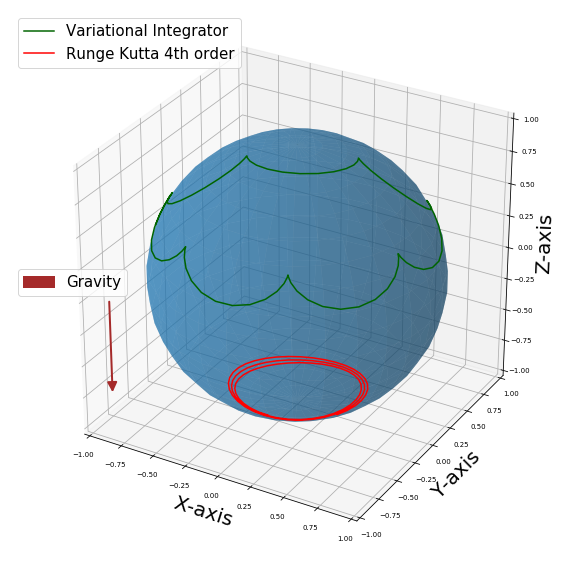

In [13]:
l = 1000 #lower interval
u = 1100 #upper interval

draw_plot(X_v[l:u], Y_v[l:u], Z_v[l:u], X_rf[l:u], Y_rf[l:u], Z_rf[l:u])

### Animation

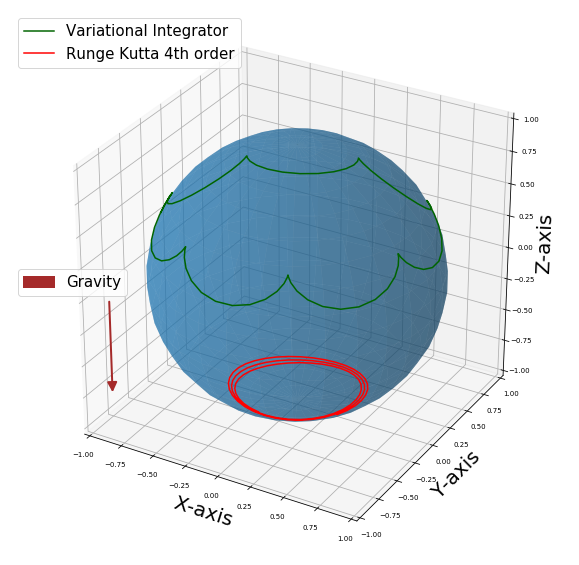

In [14]:
l = 1000 #lower interval
u = 1100 #upper interval

ani = animate_precession(X_v[l:u], Y_v[l:u], Z_v[l:u], X_rf[l:u], Y_rf[l:u], Z_rf[l:u])
ani